# Exploratory Data Analysis

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
col_names = [   'unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'TRA',
                'T2', 'T24', 'T30', 'T50', 'P2',
                'P15', 'P30', 'Nf', 'Nc', 'epr',
                'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
                'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31',
                'W32',
            ] 

In [4]:
# Importing Data for FD001

path_train_01 = r"/Users/Ameya/GitHub/TurboFanEngine_RUL-Estimator/Data/CMAPSSData/train_FD001.txt"
df_train_01 = pd.read_csv(path_train_01,
                 sep='\s+',
                 header=None,
                 index_col=False,
                 names=col_names
                 )

path_test_01 = r"/Users/Ameya/GitHub/TurboFanEngine_RUL-Estimator/Data/CMAPSSData/test_FD001.txt"
df_test_01 = pd.read_csv(path_test_01,
                 sep='\s+',
                 header=None,
                 index_col=False,
                 names=col_names
                 )

path_RUL_01 = r"/Users/Ameya/GitHub/TurboFanEngine_RUL-Estimator/Data/CMAPSSData/RUL_FD001.txt"
df_RUL_01 = pd.read_csv(path_RUL_01,
                 sep='\s+',
                 header=None,
                 index_col=False,
                 #names=col_names
                 )

In [5]:
df = df_train_01.copy()

def add_RUL(df):
    """
    Calculates maximum cycles run by every engine (unit number).
    Subtracts every cycle instance from max cycles and calculates remaining cycles for every engine
    """
    df_byUnit  = df.groupby(by='unit_number')
    max_cycles = df_byUnit['time_in_cycles'].max()
    df         = df.merge(max_cycles.to_frame(name='max_cycles'),
                         left_on = 'unit_number',
                         right_index = True
                         )
    df['RUL'] = df['max_cycles'] - df['time_in_cycles']
    return df

df = add_RUL(df)

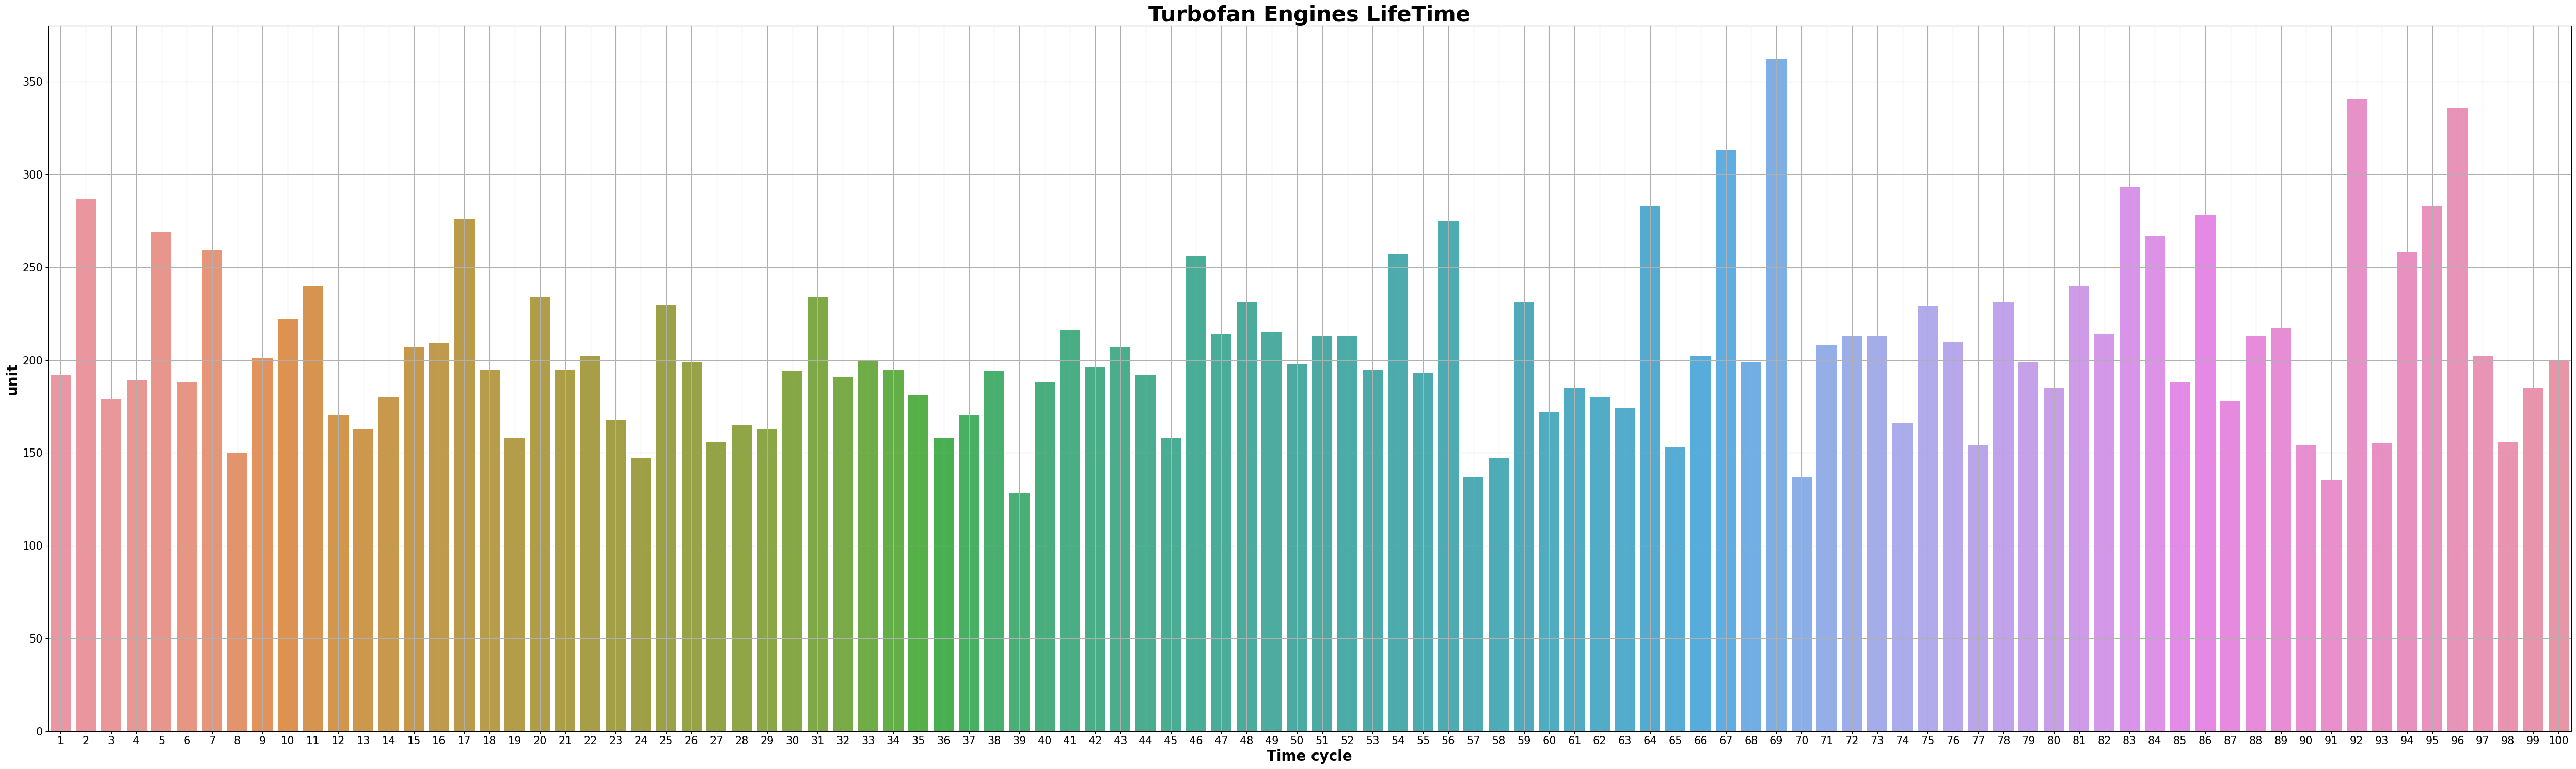

<Figure size 5000x1500 with 0 Axes>

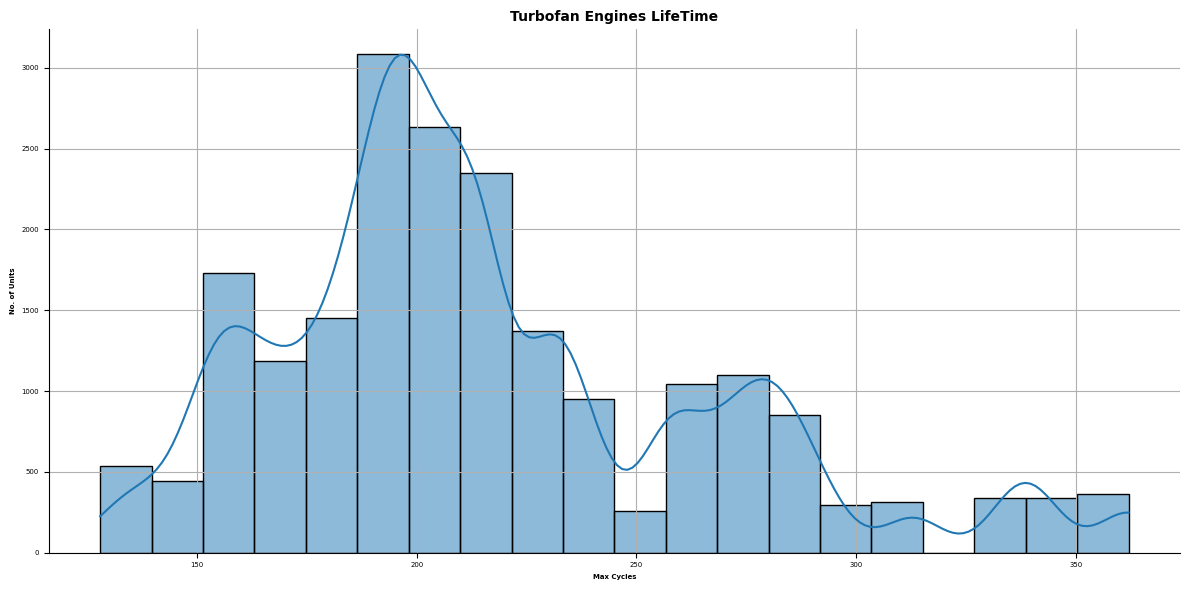

In [6]:
def plot_maxcycles(df):
    """
    1. Plots Engine number Vs. Max cycles run
    2. Frequency of max cycles
    """
    #Plot 1
    data = df[['unit_number', 'max_cycles']].groupby('unit_number').max()
    plt.figure(figsize=(50,15))
    sns.barplot(data=data,
                x = df['unit_number'],
                y = df['max_cycles'],
                )
    
    plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
    plt.xlabel('Time cycle',fontweight='bold',size=20); plt.xticks(size=15)
    plt.ylabel('unit',fontweight='bold',size=20); plt.yticks(size=15)
    plt.grid(True); plt.tight_layout(); plt.show()

    #Plot 2
    plt.figure(figsize=(50,15))
    sns.displot(df['max_cycles'],
                kde=True,
                bins=20,
                height=6,
                aspect=2
                )
    
    plt.title('Turbofan Engines LifeTime',fontweight='bold',size=10)
    plt.xlabel('Max Cycles',fontweight='bold',size=5); plt.xticks(size=5)
    plt.ylabel('No. of Units',fontweight='bold',size=5) ; plt.yticks(size=5)
    plt.grid(True); plt.tight_layout(); plt.show()

plot_maxcycles(df)

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


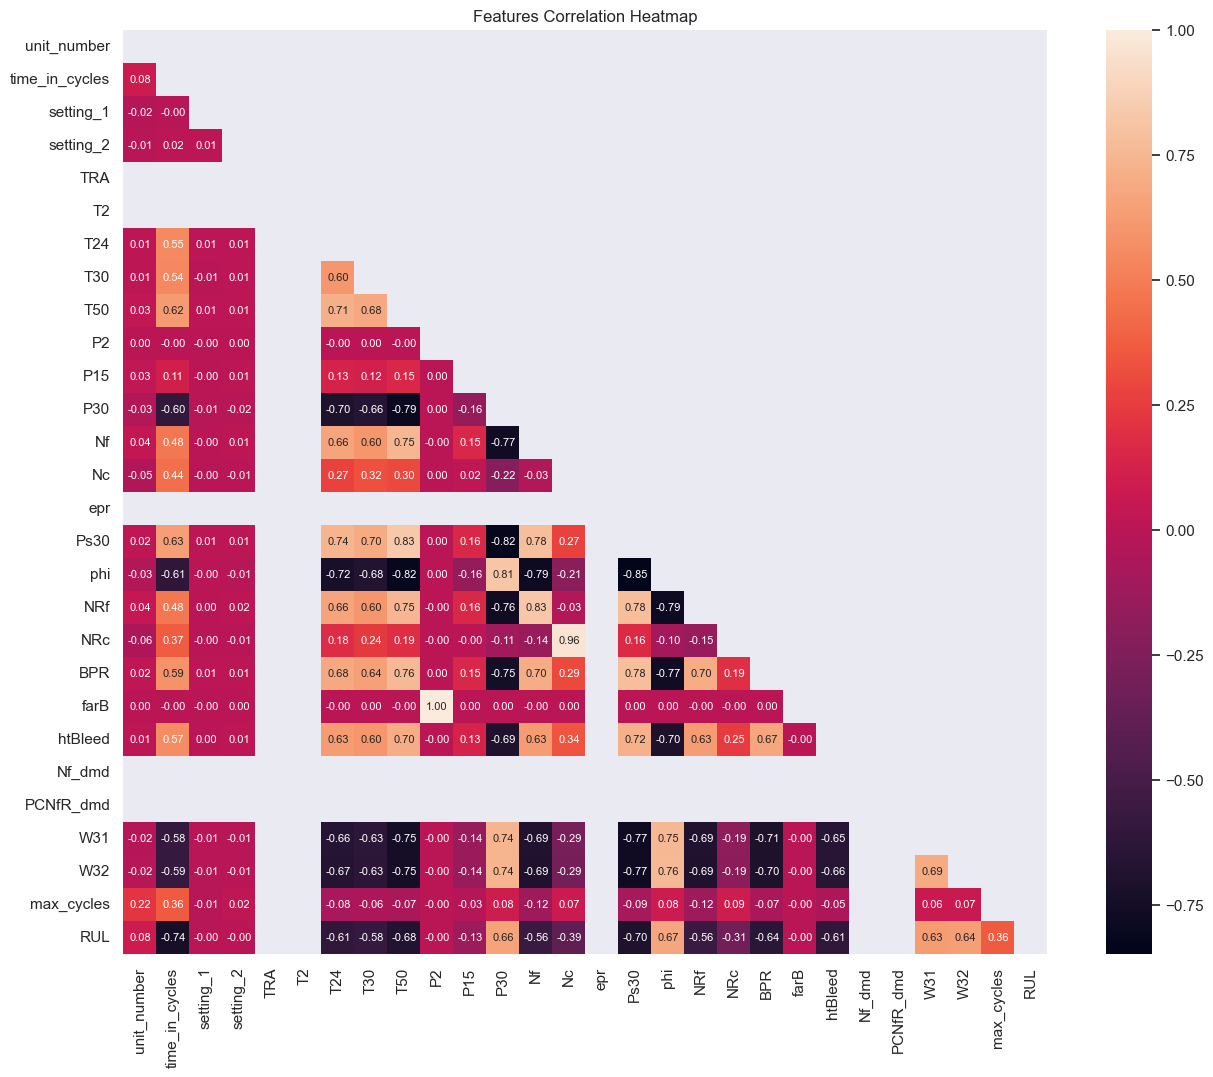

In [7]:
col_names = col_names + ['max_cycles', 'RUL']

import seaborn as sns
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.0)
mask = np.triu(np.ones_like(cm, dtype=bool))
fig = plt.figure(figsize=(15, 12))
hm = sns.heatmap(data = cm, 
                cbar=True, 
                annot=True, 
                square=True, 
                fmt='.2f', 
                annot_kws={'size': 8}, 
                yticklabels=col_names, xticklabels=col_names,
                mask = mask
                )
sns.color_palette("coolwarm", as_cmap=True)
plt.title('Features Correlation Heatmap')
plt.show()

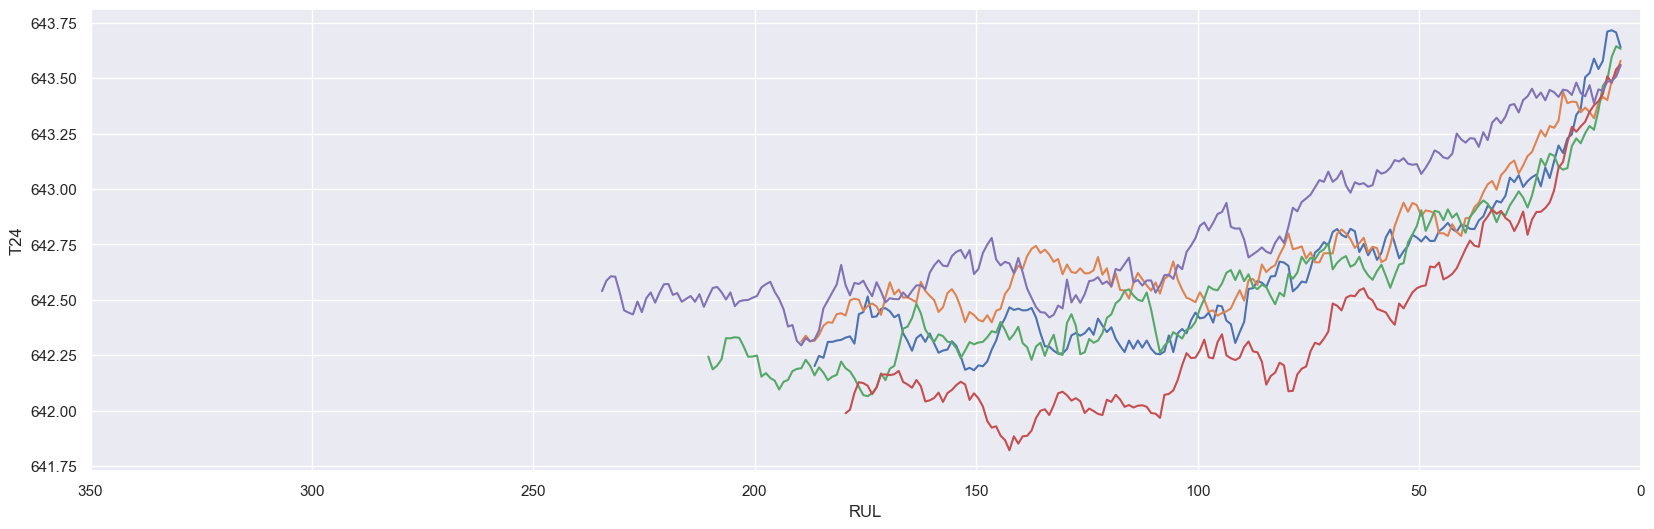

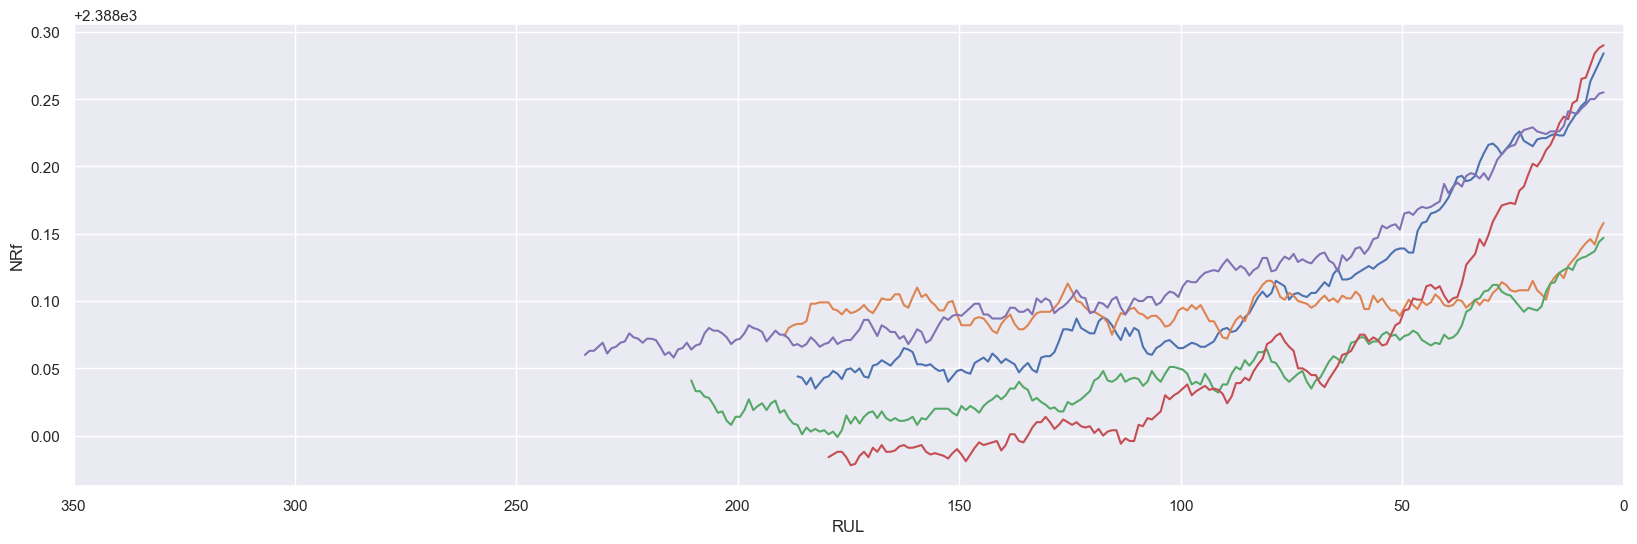

In [8]:
for  feature in ['T24', 'NRf']:
  fig = plt.figure(figsize=(20, 6)) 
  for unit in df['unit_number'].unique()[::20]:
    sns.lineplot(data = df,
            x = df[df['unit_number']==unit]['RUL'].rolling(10).mean(),
            y = df[df['unit_number']==unit][feature].rolling(10).mean(),
            #y = df['RUL'],
              )
    plt.xlim(350, 0),

In [39]:
# Adding new Feature Life Ratio (cycles/End-of Life)
df['LR'] = df['cycle'] / df['EOL']
    
def get_condition(LR):

    if LR < 0.6:
        return 0 #'Good'
    elif 0.6 <= LR <= 0.8:
        return 1 #'Moderate'
    else:
        return 2 #'Warning'  


df['condition'] = df['LR'].apply(get_condition) 

In [40]:
X_features = [  #'ID', 'cycle', 
                'setting_1', 'setting_2', 'TRA', 'T2', 'T24', 'T30',
                'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', #'phi', 'NRf', 'NRc', 
                'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32', #'EOL', 'RUL', 'LR', 'condition',
                ]

X = df[X_features]

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
def get_vif(df):
    df_matrix = df.to_numpy()
    vifs = [vif(df, i) for i in range(df_matrix.shape[1])] 
    df_vif = pd.DataFrame({
                            'Features' : list(df.columns),
                            'VIFs' : vifs,
                          })
    return df_vif

df_vif = get_vif(X)
df_vif.sort_values(by='VIFs', ascending=False)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Features,VIFs
13,Ps30,5.663371e+00
6,T50,4.425951e+00
10,Nf,4.308684e+00
9,P30,4.191716e+00
14,BPR,3.243756e+00
20,W32,3.054517e+00
19,W31,3.021131e+00
4,T24,2.602765e+00
16,htBleed,2.533591e+00
5,T30,2.267329e+00


In [48]:
X = df[X_features]
y = df['condition']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state=0)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,
                                max_depth=10)
clf_rf = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print("Training Accuracy Score : {:.3f}".format( accuracy_score(y_train, clf_rf.predict(X_train)) ))
print("Testing  Accuracy Score : {:.3f}".format( accuracy_score(y_test, clf_rf.predict(X_test)) ))
print("Best Parameters : \n{}".format( clf_rf.get_params() ))

Training Accuracy Score : 0.901
Testing  Accuracy Score : 0.843
Best Parameters : 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
random_grid = {'n_estimators' :  [100, 200, 500],
               'criterion'    : ['gini', 'entropy'],
               'max_depth'    : [10, 20, 30],
                }
model = GridSearchCV(estimator= RandomForestClassifier(), 
                    param_grid= random_grid,
                    scoring=accuracy_score,
                    cv=10)
optimizer = model.fit(X_train, y_train)